<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# ARIMA Lab

_Authors:_ Joseph Nelson (DC), Boom Devahastin Na Ayudhya (NYC), Bethany Poulin (Boston) 

---

## Introduction


The most common application for AR, ARMA, and ARIMA models is inventory planning. Planning inventory for a small shop can be difficult enough, but you've just been hired to plan inventory for a _big_ store - Walmart.

In this lab, you will be analyzing weekly Walmart sales data over a two year period from 2010 to 2012. The data is separated by store and by department, but you should focus on analyzing one store for simplicity. Your supervisor has set out the following goals for this project:

1. Record any observed trends in the data.
2. Produce a trained model to predict future sales numbers.
3. Include useful AND COMMENT ON how graphs (ACF, PACF) impact your modelling decisions throughout your notebook.

Try your best to tune your model. It can be difficult, but don't worry - time series analysis is a difficult and specialized topic.

## Exercise
---

#### Requirements

- Assemble observations and graphs as well as timeseries models in a notebook.


#### Additional Resources

1. [ARMA Example](https://www.statsmodels.org/dev/examples/notebooks/generated/tsa_arma_0.html)
2. [ARMA Models for TSA](https://www.quantstart.com/articles/Autoregressive-Moving-Average-ARMA-p-q-Models-for-Time-Series-Analysis-Part-1)

#### Things to Consider

You should always be looking for ways to reduce redundancy in your code, improve consistency in your output, and make it easier for others to follow your work! Functions are a huge part of this endeavor!

While working on this lab, you may try a number of $p$, $q$, and $d$ values to best account for your data. Because you will likely be repeating yourself, it is useful to create functions that declutter your workspace.

 - You may want to create a wrapper around the Augmented Dickey-Fuller test to provide both results and context for the output.
 - You may find value in a combined ACF & PACF function.
 - You may find it cleaner to build a function to make residual graphs and print out MSE all at once.

### Importing Necessary Libraries & Loading Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller  

%matplotlib inline

import warnings
warnings.simplefilter(action="ignore")

data = pd.read_csv('./datasets/train.csv')
data.set_index('Date', inplace=True)
data.head()

C:\Users\Razer\anaconda3\envs\dsi-sg\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


## Exploratory Analysis

#### 0. Preprocessing Data
It's always a good idea to evaluate the current state of your data. For every set of data this means something different. But the bare minimum is understanding what types of data you have, knowing if there are missing values and checking to be sure that your date column (or index) is in a proper date format.

Accordingly you should check:
 - Format of date column/index
 - Data types for each column
 - Whether or not we will have to deal with missing data

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 421570 entries, 2010-02-05 to 2012-10-26
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Weekly_Sales  421570 non-null  float64
 3   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2)
memory usage: 13.3+ MB


In [3]:
data.index = pd.to_datetime(data.index)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 421570 entries, 2010-02-05 to 2012-10-26
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Weekly_Sales  421570 non-null  float64
 3   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2)
memory usage: 13.3 MB


#### 1. Extracting Data to Model

Our data set has a number of stores, each with weekly sales volumes for many departments. 

To facilitate our first time series model, we need to use a single store, and aggregate the total sales for all departments.

**Aggregate all of the sales for STORE 1 into a new dataframe called `Weekly_Sales`.**


In [4]:
mask = data['Store'] == 1
data = data[mask]
Weekly_Sales = pd.DataFrame(data['Weekly_Sales'].groupby(data.index).sum())

#### 2. Plotting & Interpreting Time Series

Plots are a central part of all time series analysis. You should always start with a basic line plot.

**2a. Generate a line plot for `Weekly_Sales` with time on the $x$-axis.**

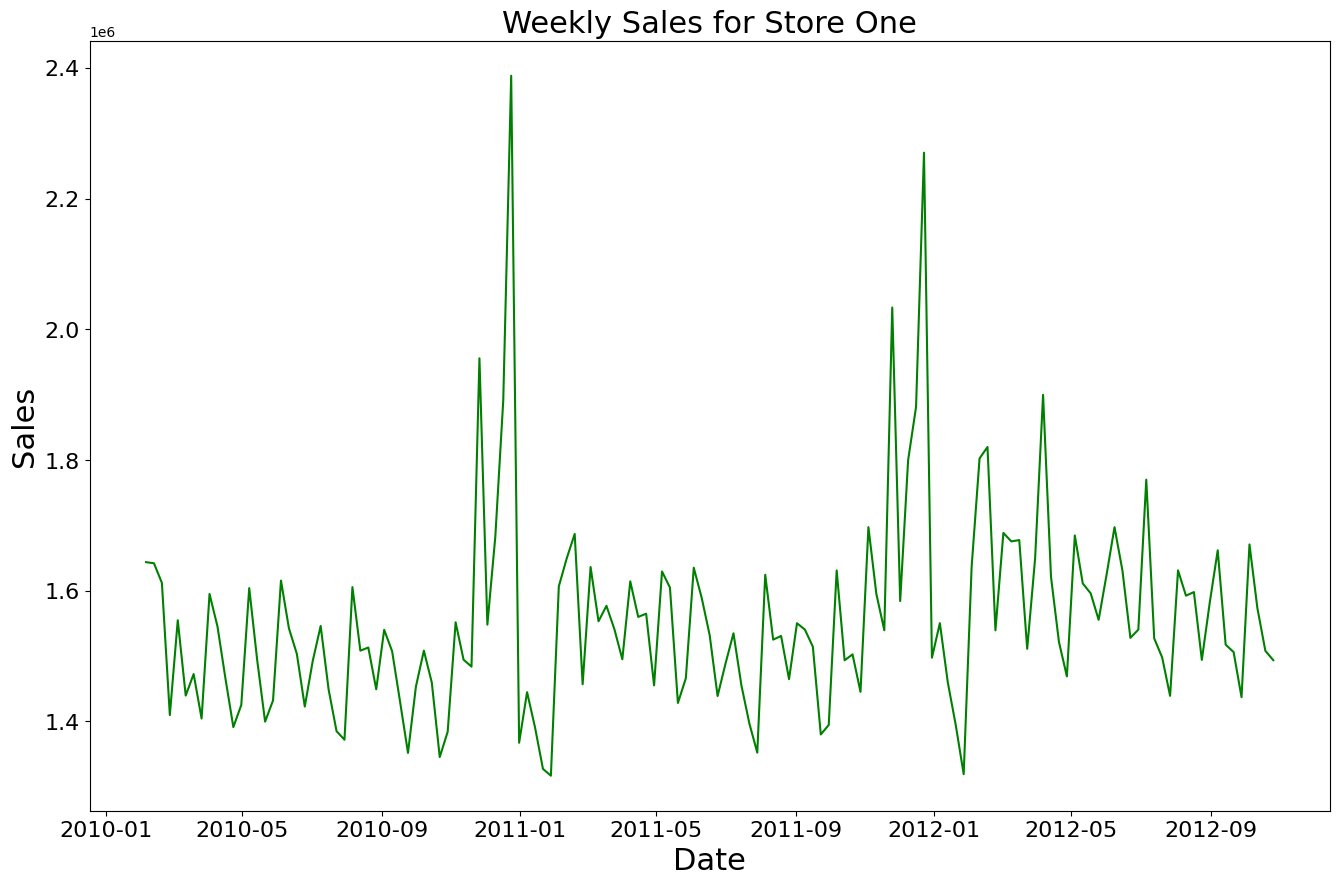

In [5]:
# Set figure size.
plt.figure(figsize=(16,10))

# Create line plot.
plt.plot(Weekly_Sales, c ='green')

# Set labels and title.
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Date', fontsize=22)
plt.ylabel('Sales', fontsize=22)
plt.title('Weekly Sales for Store One', fontsize=22);

Smoothing can help us see trends in the data. With time series, this frequently means plotting a rolling mean.

You might start looking at a one week roll, but you consider several 'windows' of time. 
 - What would a four week rolling mean look like? 
 - How about quarterly? 
 - Or annually? 

**2b. Calculate the rolling mean(s) for `Weekly_Sales` then plot them on a single set of axes.**

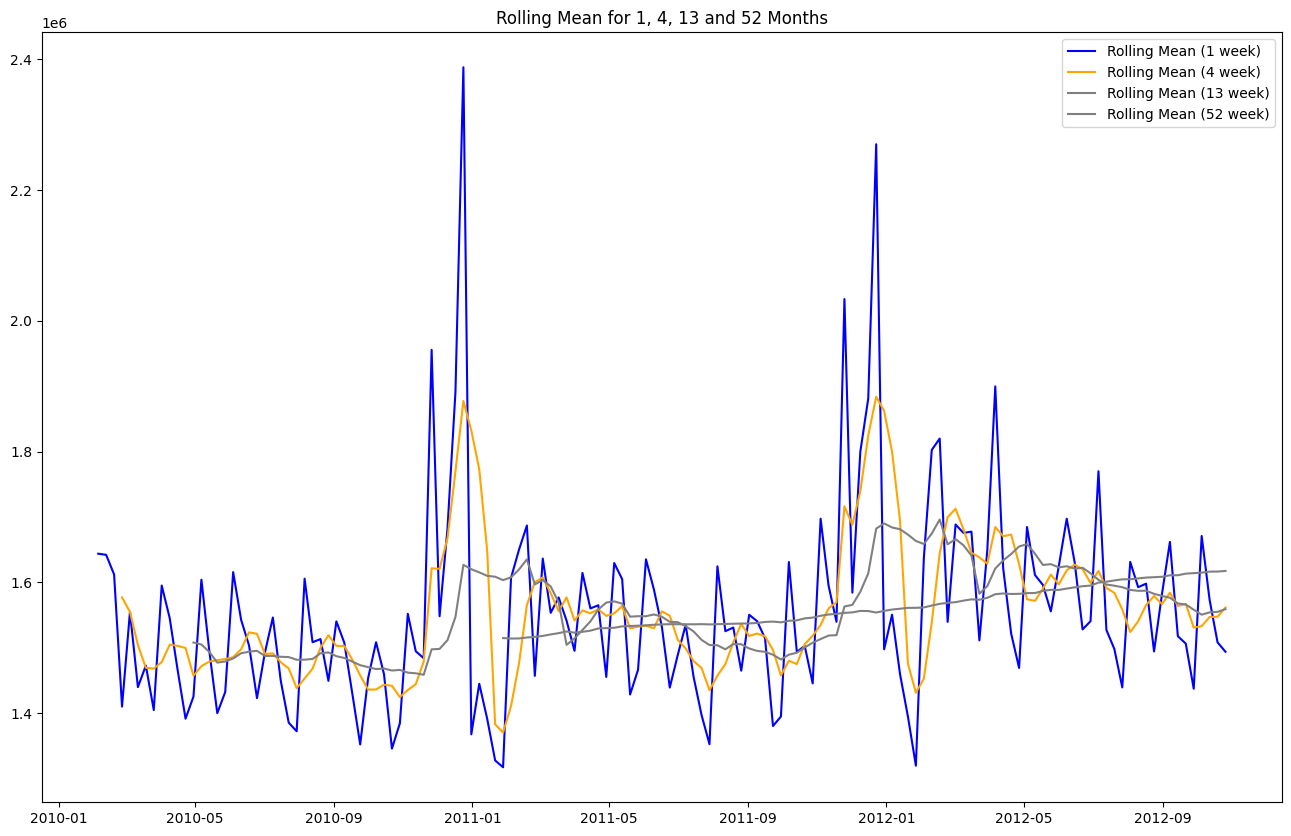

In [6]:
# Set a rolling mean with windows of 1, 4, 13 and 52.
rolmean1  = Weekly_Sales.rolling(window = 1).mean()
rolmean4  = Weekly_Sales.rolling(window = 4).mean()
rolmean13 = Weekly_Sales.rolling(window = 13).mean()
rolmean52 = Weekly_Sales.rolling(window = 52).mean()

# Plot
plt.figure(figsize=(16,10))
plt.plot(rolmean1, color='blue', label='Rolling Mean (1 week)')
plt.plot(rolmean4, color='orange', label='Rolling Mean (4 week)')
plt.plot(rolmean13, color='grey', label='Rolling Mean (13 week)')
plt.plot(rolmean52, color='grey', label='Rolling Mean (52 week)')

plt.legend(loc='best')

plt.title('Rolling Mean for 1, 4, 13 and 52 Months')
plt.show()

**2c. What can you say about trends in the data based on the rolling mean plot above?**

*Answer:* There are spikes in Dec/Jan, most likely due to the holidays. After that, there is a huge decrease.

#### 3. Autocorrelations

We've learned about autocorrelation: the influence a serial observation has on the observations which follow.

Calculate autocorrelation in your `Weekly_Sales` data so that you can answer the question: 'How does autocorrelation differ as lag-weeks vary?'

**3a. Check at least three lag intervals (but feel free to explore others):**
 - **1 week**
 - **2 weeks**
 - **1 year (52 weeks)**

In [7]:
print(f'Autocorrelation between Weekly Sales and 1-lag Weekly_Sales: {round(Weekly_Sales["Weekly_Sales"].autocorr(lag=1),4)}')
print(f'Autocorrelation between Weekly Sales and 2-lag Weekly_Sales: {round(Weekly_Sales["Weekly_Sales"].autocorr(lag=2),4)}')
print(f'Autocorrelation between Weekly Sales and 52-lag Weekly_Sales: {round(Weekly_Sales["Weekly_Sales"].autocorr(lag=52),4)}')

Autocorrelation between Weekly Sales and 1-lag Weekly_Sales: 0.3022
Autocorrelation between Weekly Sales and 2-lag Weekly_Sales: 0.1274
Autocorrelation between Weekly Sales and 52-lag Weekly_Sales: 0.8954


**3b. What can you say about the series based on these autocorrelations?**

Answer: The 52-lag autocorrelation is the highest, which means that there is a strong seasonal influence on sales lagged by 1 year.

**3c. Plotting ACF and PCF**
As we learned in lecture, plotting the `Autocorrelation Function` and `Partial Autocorrelation Functions` can be useful in understanding seasonality in time series data.

Make a 52-week `ACF` and 52-week `PACF` plot now.

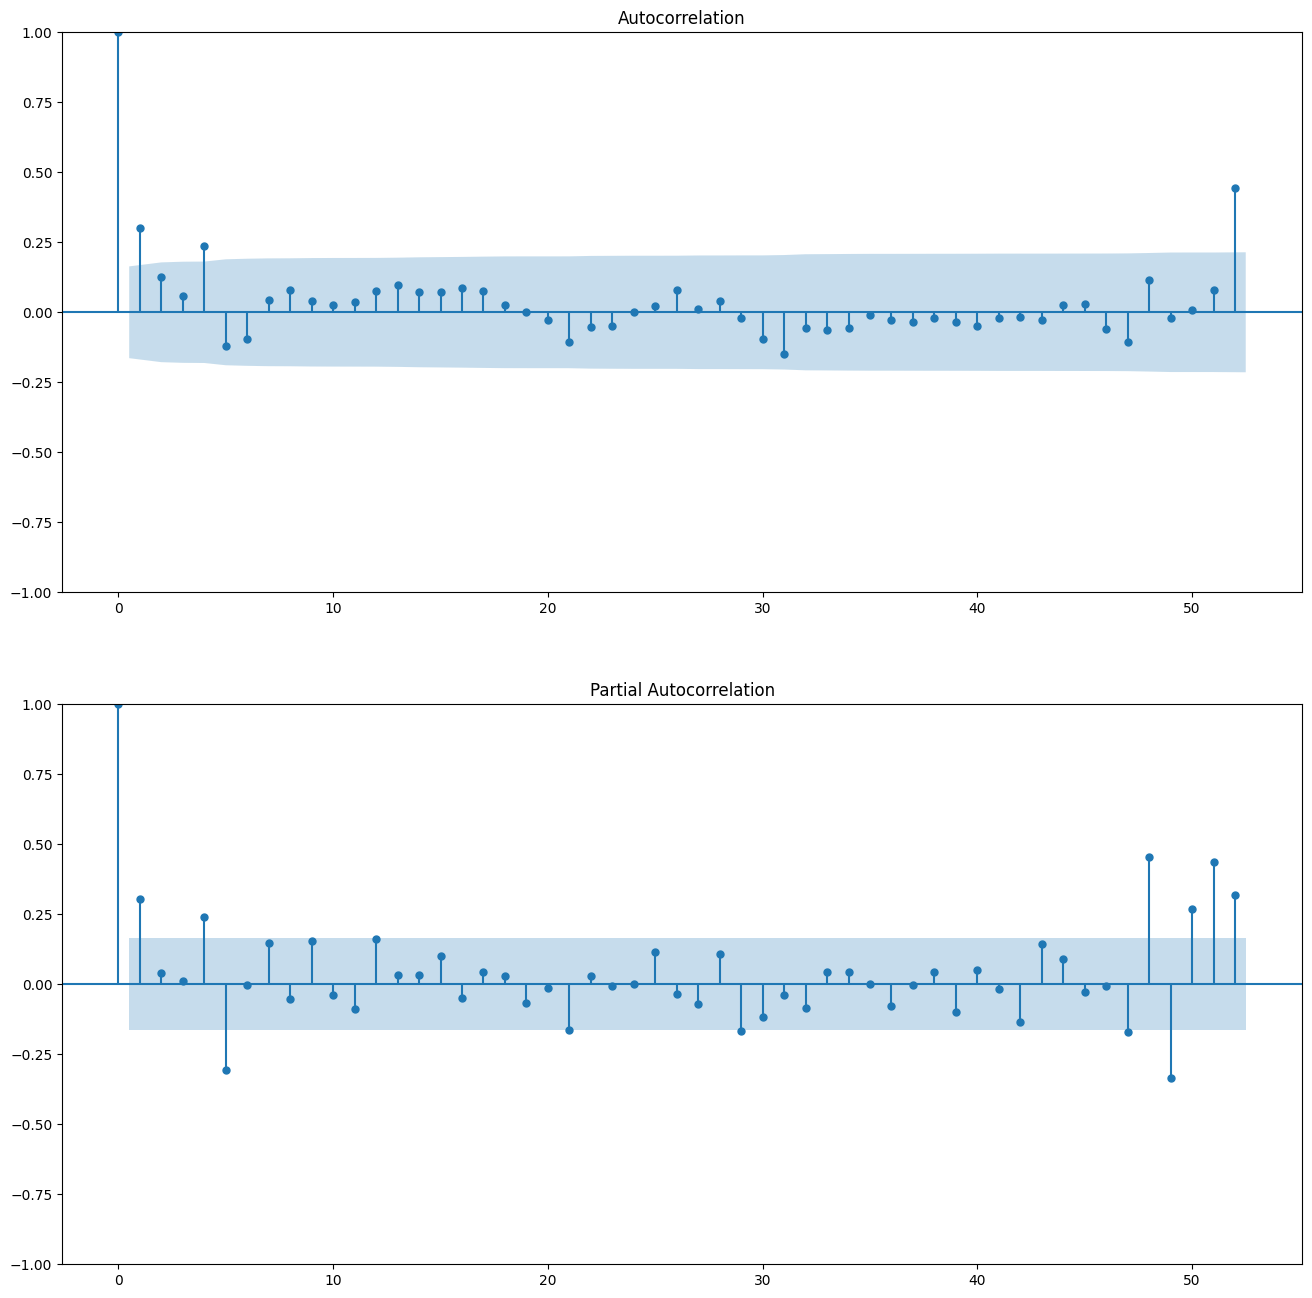

In [8]:
fig = plt.figure(figsize=(16,16))
ax1 = fig.add_subplot(211)
fig = plot_acf(Weekly_Sales, lags=52, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(Weekly_Sales, lags=52, ax=ax2);

#### 4. Interpreting the `ACF` and `PACF` Plots

**4a. What do the ACF and PACF graphs tell you about your sales data?**

Answer: At lag 1 and 4, there is a correlation between sales and lag 1 or 4 sales by both ACF and PACF. At lag 52, there is a clear correlation in ACF and PACF. At lag 5, there is a negative relationship in PACF.

**4b. How do the `ACF` and `PACF` inform your model selections moving forward?**

Answer: This guides the value of p and q.

## Modeling

**5. Train/Test Split**  

Modeling with time series data presents unique challenges because our observations are not independent of one another. 

So, in splitting the data into `training` and `test` sets, **we cannot split randomly**. Use the first *75%* of observations as training data and the following 25% for test data.

In [9]:
print(f'Number of observations: {len(Weekly_Sales)}')
print(f'Number of training observations: {round(len(Weekly_Sales) * 0.75)}')
print(f'Number of testing observations: {len(Weekly_Sales) - round(len(Weekly_Sales) * 0.75)}')

train = Weekly_Sales.iloc[:108,]

test = Weekly_Sales.iloc[108:,]

Number of observations: 143
Number of training observations: 107
Number of testing observations: 36


#### 6. Autoregressive Model

We will start by building a simple autoregressive model first: the `AR(1)` model. In each section, we will add additional ARIMA parameters in an effort to improve our modeling. Note that sometimes the model you attempt is not effective or the best -- try the BONUS sections below to see other approaches to modeling this dataset!

- Note that this is the same thing as an `ARIMA(1,0,0)` model.
- Pass in the Weekly Sales as an `ndarray`, not a `Series`.
- Pass in the training index using the ARIMA `dates` parameter.

**6a. Instantiate and fit an `AR(1)` model.**

In [10]:
from statsmodels.tsa.arima.model import ARIMA
# Split training data into train values and dates.
train_values = train['Weekly_Sales'].values
train_dates = train.index

# Fit model on training data.
AR1 = ARIMA(train_values, 
            dates = train_dates, 
            order = (1,0,0)).fit()

# Split test data into values and dates.
test_values = test['Weekly_Sales'].values
test_dates  = test.index

# Create start and end dates for predictions
start = test.index[0]
end = test.index[-1]

# Generate predictions on starting and ending dates.
AR1_pred = AR1.predict(start = len(train_values),
                       end = len(train_values) + len(test_values)-1)

# Put predictions into a dataframe with a date range.
date_list =  pd.date_range(start, periods=35, freq ='W')
preds = pd.DataFrame(AR1_pred, index=date_list, columns = ['Weekly Sales'])

**6b. Calculate the Mean Squared Error of the `AR(1)` on your training set and your test set.**


In [11]:
AR1_pred

array([1542396.88243029, 1543319.27047436, 1543602.01719399,
       1543688.6897262 , 1543715.25812582, 1543723.40234223,
       1543725.89885168, 1543726.66412597, 1543726.8987114 ,
       1543726.97062068, 1543726.99266359, 1543726.99942057,
       1543727.00149184, 1543727.00212676, 1543727.00232139,
       1543727.00238105, 1543727.00239934, 1543727.00240495,
       1543727.00240666, 1543727.00240719, 1543727.00240735,
       1543727.0024074 , 1543727.00240742, 1543727.00240742,
       1543727.00240742, 1543727.00240742, 1543727.00240742,
       1543727.00240742, 1543727.00240742, 1543727.00240742,
       1543727.00240742, 1543727.00240742, 1543727.00240742,
       1543727.00240742, 1543727.00240742])

In [12]:
# Calculate MSE.
error = mean_squared_error(test_values, preds)
print(f'MSE: {round(error, 2)}')

MSE: 11496534849.29


**6c. How effective do you think this `AR(1)` model is?**

Answer: Not very effective as MSE is extremely large. This is a very simple model and hence is unable to capture the complex relationship and patterns of the underlying data.

#### 7. Residual Plot  
Mean squared error is a good way to evaluate our model's performance. However, this doesn't tell the whole story. Is our model off by a lot in one specific window of time? Is our model only slightly off, but over all time? It might be helpful to plot residuals to see when our model is off most.

**7a. Calculate and and plot the residuals of your `AR(1)` model. (*Remember that a residual is just the actual value minus the predicted value.*)**

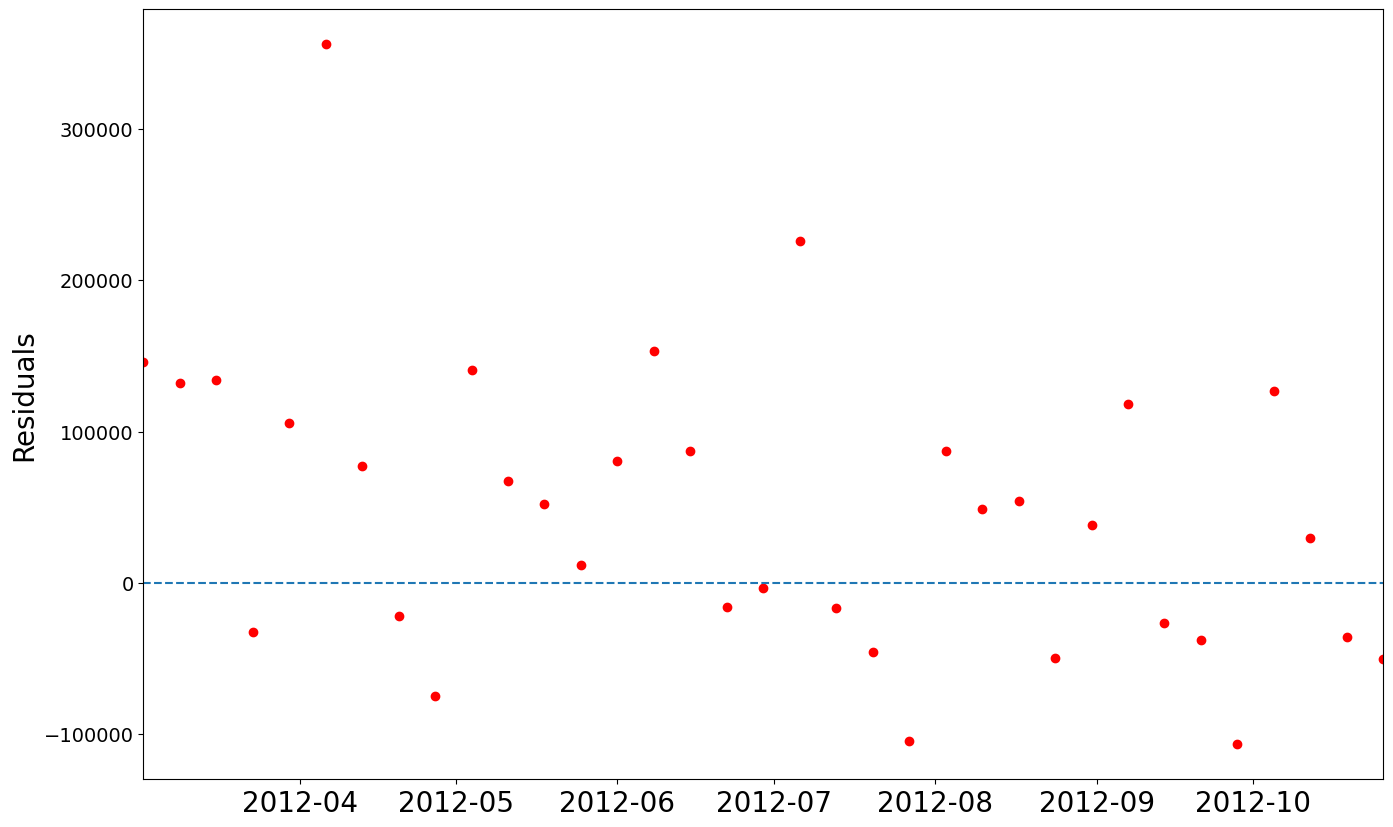

In [13]:
plt.figure(figsize=(16,10))

# Calculate residuals.
resids = test['Weekly_Sales'].values - preds['Weekly Sales'].values

# Generate scatterplot of residuals.
plt.scatter(test['Weekly_Sales'].index, resids, c ='red')

# Plot baseline at y=0.
plt.hlines(y = 0,
           xmin = test['Weekly_Sales'].index.min(),
           xmax = test['Weekly_Sales'].index.max(),
           linestyles = '--')

# Set labels and axes.
plt.xticks(fontsize=20)
plt.xlim(test['Weekly_Sales'].index.min(), test['Weekly_Sales'].index.max())
plt.yticks(fontsize=14)
plt.ylabel('Residuals', fontsize = 20);

From this plot we can see that there are clearly errors in our predictions. 

**7b. What do the residual plots reveal about our model?**

Answer: There are days where predictions are very off, compared to the rest.

#### 8. AR vs. ARMA Models 


**8a. Let's fit an `AR(2)` model. Calculate the MSE on the training and testing sets, then plot the residuals.**

In [14]:
# Fit model on training data.
AR2 = ARIMA(train_values, 
            dates = train_dates, 
            order = (2,0,0)).fit()

# Split test data into values and dates.
test_values = test['Weekly_Sales'].values
test_dates  = test.index

# Create start and end dates for predictions
start = test.index[0]
end = test.index[-1]

# Generate predictions on starting and ending dates.
AR2_pred = AR2.predict(start = len(train_values),
                       end = len(train_values) + len(test_values)-1)

# Put predictions into a dataframe with a date range.
date_list =  pd.date_range(start, periods=35, freq ='W')
preds = pd.DataFrame(AR2_pred, index=date_list, columns = ['Weekly Sales'])

# Calculate MSE.
error = mean_squared_error(test_values, preds)
print(f'MSE: {round(error, 2)}')

MSE: 11333914061.72


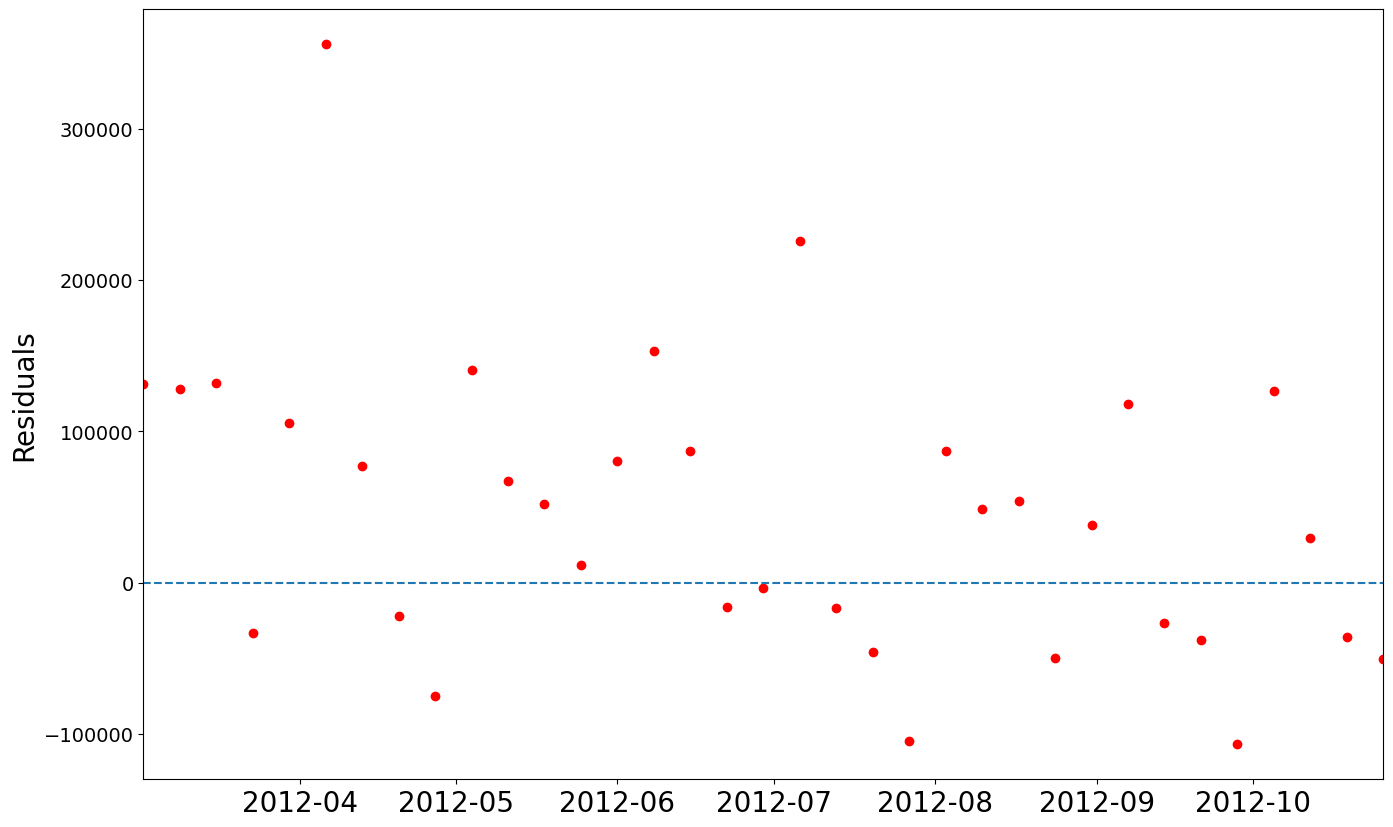

In [15]:
# Set figure size.
plt.figure(figsize=(16,10))

# Calculate residuals.
resids = test['Weekly_Sales'].values - preds['Weekly Sales'].values

# Generate scatterplot of residuals.
plt.scatter(test['Weekly_Sales'].index, resids, c ='red')

# Plot baseline at y=0.
plt.hlines(y = 0,
           xmin = test['Weekly_Sales'].index.min(),
           xmax = test['Weekly_Sales'].index.max(),
           linestyles = '--')

# Set labels and axes.
plt.xticks(fontsize=20)
plt.xlim(test['Weekly_Sales'].index.min(), test['Weekly_Sales'].index.max())
plt.yticks(fontsize=14)
plt.ylabel('Residuals', fontsize = 20);

**8b. How did your results change?**

Answer: About the same.

**8c. Fit an `ARMA(2,2)` model. Calculate the MSE on the training and testing sets, then plot the residuals.** (_Note that an `ARMA(2,2)` model is the same as an `ARIMA(2,0,2)` model._)

In [16]:
# Fit model on training data.
AR2_2 = ARIMA(train_values, 
            dates = train_dates, 
            order = (2,0,2)).fit()

# Generate predictions on starting and ending dates.
AR2_2_pred = AR2_2.predict(start = len(train_values),
                       end = len(train_values) + len(test_values)-1)

# Put predictions into a dataframe with a date range.
date_list =  pd.date_range(start, periods=35, freq ='W')
preds = pd.DataFrame(AR2_2_pred, index=date_list, columns = ['Weekly Sales'])

# Calculate MSE.
error = mean_squared_error(test_values, preds)
print(f'MSE: {round(error, 2)}')

MSE: 11379294340.03


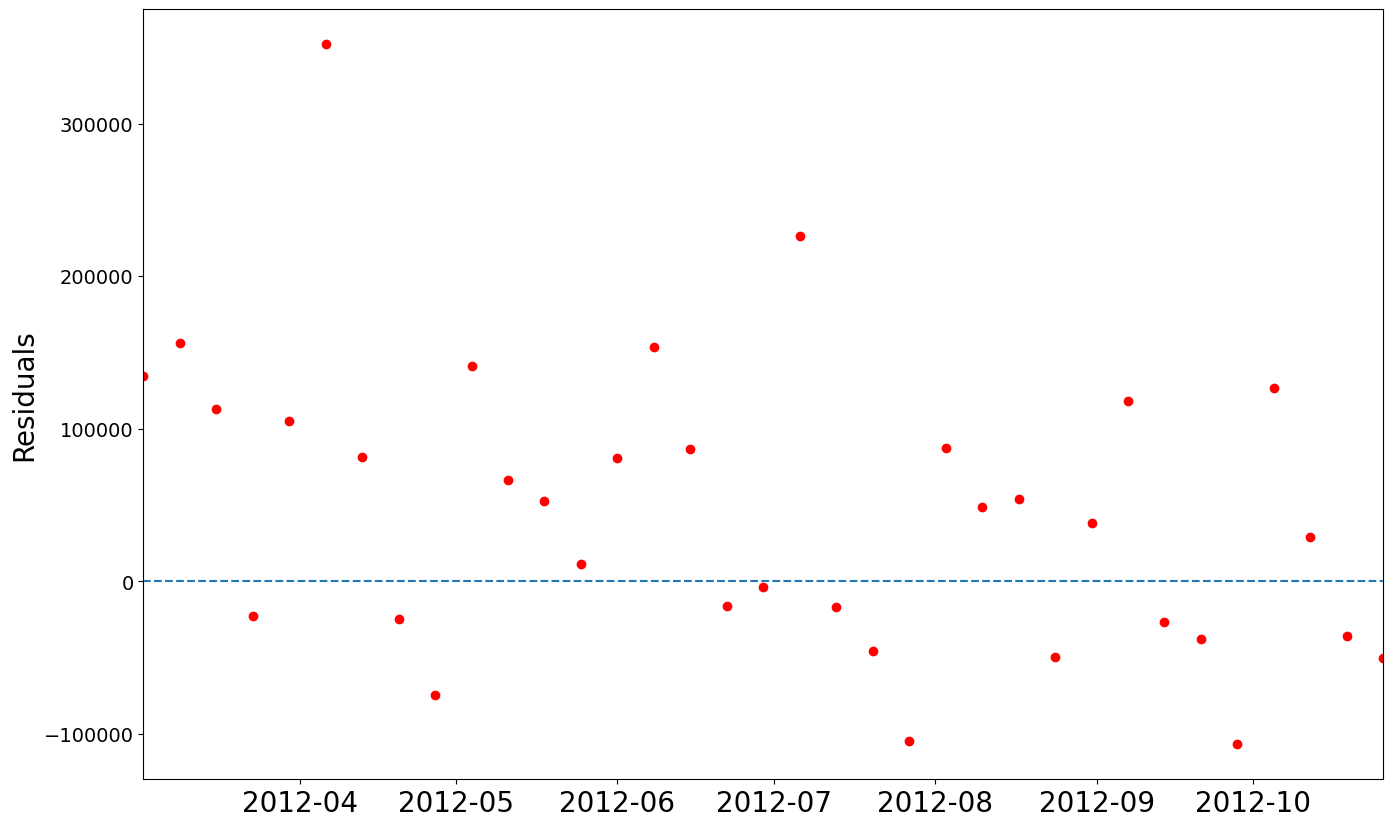

In [17]:
# Set figure size.
plt.figure(figsize=(16,10))

# Calculate residuals.
resids = test['Weekly_Sales'].values - preds['Weekly Sales'].values

# Generate scatterplot of residuals.
plt.scatter(test['Weekly_Sales'].index, resids, c ='red')

# Plot baseline at y=0.
plt.hlines(y = 0,
           xmin = test['Weekly_Sales'].index.min(),
           xmax = test['Weekly_Sales'].index.max(),
           linestyles = '--')

# Set labels and axes.
plt.xticks(fontsize=20)
plt.xlim(test['Weekly_Sales'].index.min(), test['Weekly_Sales'].index.max())
plt.yticks(fontsize=14)
plt.ylabel('Residuals', fontsize = 20);

**8d. How do the errors and residuals change from `AR(2)` to `ARMA(2,2)`?**



Answer: Still about the same.

#### 9. Stationary Data

Remember that one assumption to using the ARIMA model is that our data are **stationary**. This is a necessary assumption for our model, and it is important for us to check for it whenever we fit a time series model.

**9a. Use the Augmented Dickey-Fuller test to estimate whether or not your data are stationary.**

In [18]:
def my_dickey_fuller(data):
    data = data.dropna()
    print('\t\t\033[1mResults of Dickey-Fuller Test\033[0m\n\n')
    df_test = adfuller(data, maxlag=0, autolag=None)
    
    print(f'Test Statistic \t\t\t\t {round(df_test[0],2)}')
    print(f'p-value \t\t\t\t {df_test[1]}')
    print(f'Lags Used \t\t\t\t {round(df_test[2],2)}')
    print(f'Number of Observations \t\t\t {round(df_test[3],2)}')
    
    for key, value in df_test[4].items():
        print(f'Critical Value {key} \t\t\t {round(value, 2)}')

my_dickey_fuller(train['Weekly_Sales'])

		Results of Dickey-Fuller Test


Test Statistic 				 -7.46
p-value 				 5.277167250610254e-11
Lags Used 				 0
Number of Observations 			 107
Critical Value 1% 			 -3.49
Critical Value 5% 			 -2.89
Critical Value 10% 			 -2.58


**9b. Interpret the results of the Augmented Dickey-Fuller test.**

Answer: As p-value is < 0.05, reject H0 and say that data is stationary. No differencing is required.

#### 10. Differenced Data

**10a. Create new columns in your `Weekly_Sales` dataframe.**
- One column should be `Weekly_Sales` differenced by 1 time period.
- Another column should be `Weekly_Sales` differenced by 2 time periods.
- Another column should be `Weekly_Sales` differenced by 3 time periods.
- Another column should be `Weekly_Sales` differenced by 4 time periods.

In [19]:
Weekly_Sales['diff_1'] = Weekly_Sales['Weekly_Sales'].diff()
Weekly_Sales['diff_2'] = Weekly_Sales['Weekly_Sales'].diff(2)
Weekly_Sales['diff_3'] = Weekly_Sales['Weekly_Sales'].diff(3)

**10b. Conduct and interpret the Augmented Dickey-Fuller test on each differenced column to test for stationarity.**

In [20]:
print('Original Data')
print('')
my_dickey_fuller(Weekly_Sales['Weekly_Sales'])
print('')
for diff in range(1,4):
    print(f'Data Differenced by d = {diff}')
    print('')
    my_dickey_fuller(Weekly_Sales[f'diff_{diff}'])
    print('')

Original Data

		Results of Dickey-Fuller Test


Test Statistic 				 -8.67
p-value 				 4.5968274410763635e-14
Lags Used 				 0
Number of Observations 			 142
Critical Value 1% 			 -3.48
Critical Value 5% 			 -2.88
Critical Value 10% 			 -2.58

Data Differenced by d = 1

		Results of Dickey-Fuller Test


Test Statistic 				 -17.5
p-value 				 4.3860500615947114e-30
Lags Used 				 0
Number of Observations 			 141
Critical Value 1% 			 -3.48
Critical Value 5% 			 -2.88
Critical Value 10% 			 -2.58

Data Differenced by d = 2

		Results of Dickey-Fuller Test


Test Statistic 				 -10.21
p-value 				 5.551624171726905e-18
Lags Used 				 0
Number of Observations 			 140
Critical Value 1% 			 -3.48
Critical Value 5% 			 -2.88
Critical Value 10% 			 -2.58

Data Differenced by d = 3

		Results of Dickey-Fuller Test


Test Statistic 				 -10.31
p-value 				 3.2166647330955138e-18
Lags Used 				 0
Number of Observations 			 139
Critical Value 1% 			 -3.48
Critical Value 5% 			 -2.88
Critical Valu

**10c. For which (if any) of the columns does it seem meaningful to have differenced the data?**

Answer: Not meaningful to difference the data since d = 0 is sufficient.

**10d. Based on these tests and the ACF/PACF plots above, do you think that using an Integrated AutoRegressive Moving Average (ARIMA) model makes sense? Why or why not?**

Answer: It might not improve the model since the data is stationary.

#### 11.  ARIMA MODEL

Based on your interpretation of the results from your tests for stationarity, and information gleaned from your ACF and PACF plots, choose a value of `d` to use in the `ARIMA(2,d,2)`.

**11a. Fit an `ARIMA(2,d,2)` model for the value of `d` you have chosen. Evaluate your model on the training and testing sets and generate a residual plot.**

In [21]:
# Fit model on training data.
ARIMA_2_1_2 = ARIMA(train_values, 
            dates = train_dates, 
            order = (2,1,2)).fit()

# Generate predictions on starting and ending dates.
ARIMA_2_1_2_pred = ARIMA_2_1_2.predict(start = len(train_values),
                       end = len(train_values) + len(test_values)-1)

# Calculate MSE.
error = mean_squared_error(test_values, ARIMA_2_1_2_pred)
print(f'MSE: {round(error, 2)}')

MSE: 10599783598.52


**11b. Interpret the results from the last answer.**


Answer: MSE decreased. Using setting d = 1 even though data is already stationary seem to improve the model performance.

#### 12.  SARIMAX Model
We have looked at autocorrelation of neighboring values (i.e. comparing $Y_t$ to $Y_{t-1}$ or $Y_t$ to $Y_{t-4}$). However, what about seasonal affects on our data? How might the sales today be related to sales 6 months ago or a year ago?

Let's build a SARIMAX model!

**12a. Using `PACF` and `ACF` plots with appropriate intervals (think months in a year) try to build the best SARIMAX model you can in setting the `seasonal_order = (P, D, Q, S)` and using `order = (2, 0, 2)`, fit and evaluate the model as we have done in the prior models**.

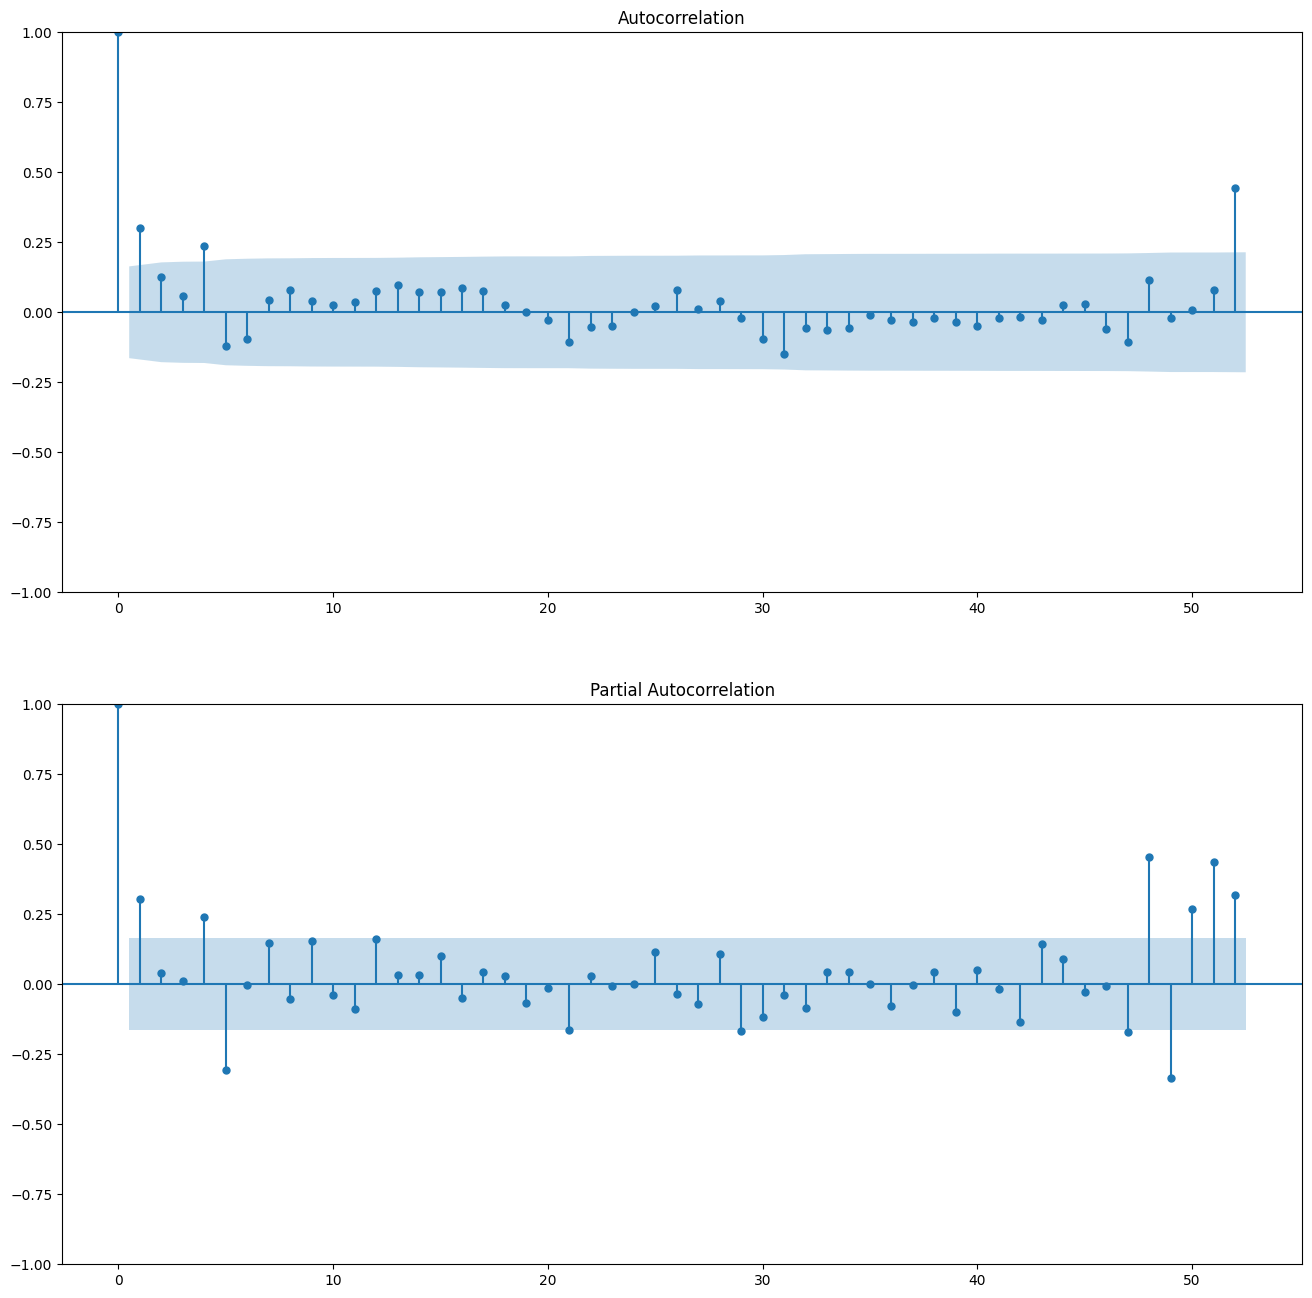

In [22]:
fig = plt.figure(figsize=(16,16))
ax1 = fig.add_subplot(211)
fig = plot_acf(Weekly_Sales.Weekly_Sales, lags=52, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(Weekly_Sales.Weekly_Sales, lags=52, ax=ax2)
plt.show();

In [23]:
sarima = SARIMAX(endog = train['Weekly_Sales'].dropna(),
                 order = (2, 0, 2),
                 seasonal_order = (0, 1, 0, 53)).fit()

sarima_pred = sarima.predict(start=start, end = end)

mean_squared_error(test_values, sarima_pred)

14361260443.5696

**12b. How did your best SARIMAX model perform?**

Answer: Arima was better.

### 13. Your Best Model

**13a. In the cells below, bring together your best model, including:**
- any summaries, 
- graphs of the data and residuals, 
- the predictions,
- and how you decided this was your best model.

In [24]:
# Fit model on training data.
ARIMA_2_1_2 = ARIMA(train_values, 
            dates = train_dates, 
            order = (2,1,2)).fit()

# Generate predictions on starting and ending dates.
ARIMA_2_1_2_pred = ARIMA_2_1_2.predict(start = len(train_values),
                       end = len(train_values) + len(test_values)-1)

# Calculate MSE.
error = mean_squared_error(test_values, ARIMA_2_1_2_pred)
print(f'MSE: {round(error, 2)}')

MSE: 10599783598.52


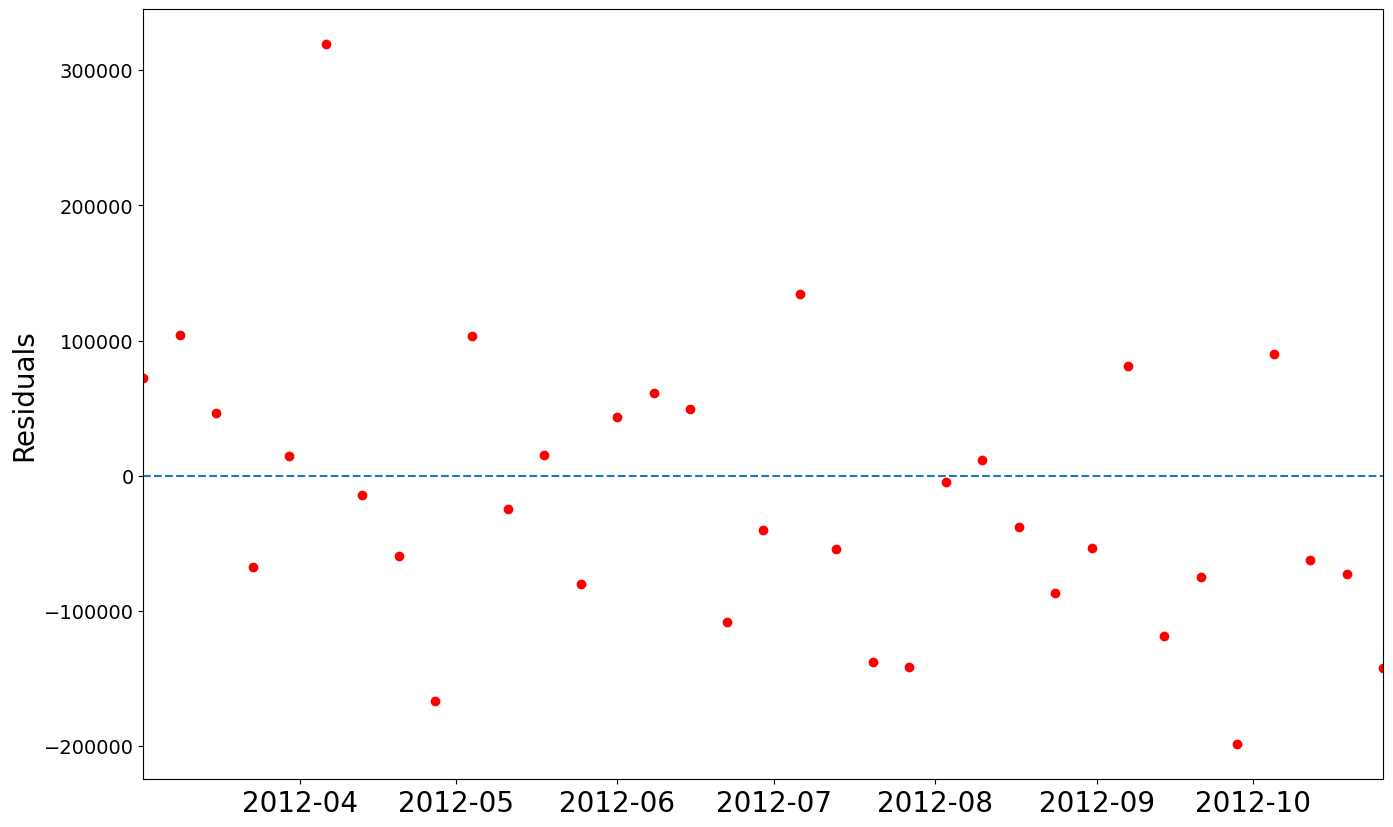

In [25]:
# Put predictions into a dataframe with a date range.
date_list =  pd.date_range(start, periods=35, freq ='W')
preds = pd.DataFrame(ARIMA_2_1_2_pred, index=date_list, columns = ['Weekly Sales'])

# Set figure size.
plt.figure(figsize=(16,10))

# Calculate residuals.
resids = test['Weekly_Sales'].values - preds['Weekly Sales'].values

# Generate scatterplot of residuals.
plt.scatter(test['Weekly_Sales'].index, resids, c ='red')

# Plot baseline at y=0.
plt.hlines(y = 0,
           xmin = test['Weekly_Sales'].index.min(),
           xmax = test['Weekly_Sales'].index.max(),
           linestyles = '--')

# Set labels and axes.
plt.xticks(fontsize=20)
plt.xlim(test['Weekly_Sales'].index.min(), test['Weekly_Sales'].index.max())
plt.yticks(fontsize=14)
plt.ylabel('Residuals', fontsize = 20);

**13b. How does our model perform at predicting weekly sales moving forward?** 

Answer: MSE of 10599783598.52. Best model so far at predicting weekly sales moving forward.

**13c. How might you improve it?**

Answer: Gather more data and import relevant exogenous data.

### 14. BONUS: Rolling Predictions

**Try testing the performance of your model using rolling predictions. For each testing observation $Y_t$ you should train your model using data up to $Y_{t-1}$. This allows us to make meaningful predictions for all testing observations** 

Answer: